# Corrective RAG (CRAG)

Corrective-RAG (CRAG) is a strategy for RAG that incorperates self-reflection / self-grading on retrieved documents. 

We will borrow some ideas from the [paper](https://arxiv.org/pdf/2401.15884.pdf):

* Retrieve documents
* Evaluate them for relevance to the user question
* Use web search as a fallback if any documents are not relevant 
 
We implement these ideas from scratch using Mistral and [LangGraph](https://python.langchain.com/docs/langgraph):

* We use a graph to represent the control flow
* The graph state includes information (question, documents, etc) that we want to pass between nodes 
* Each graph node modifies the state 
* Each graph edge decides which node to visit next

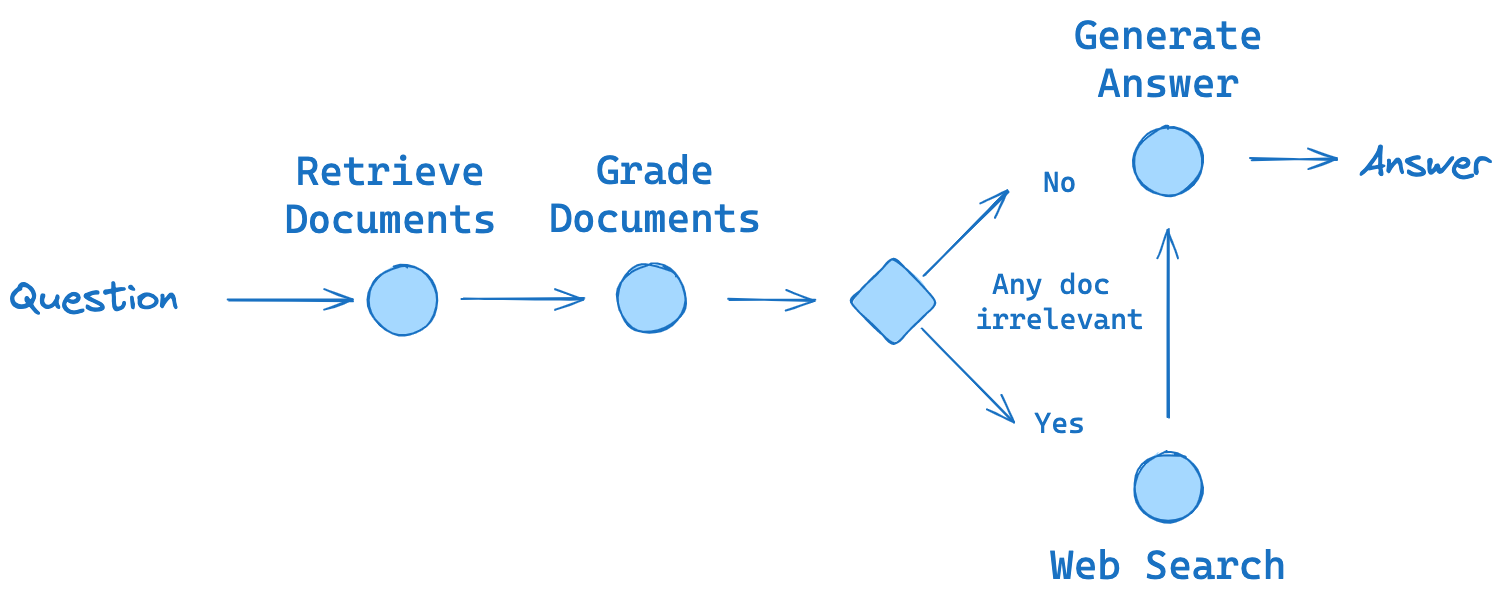

# Enviornment 

In [4]:
! pip install -U --quiet langchain_community tiktoken langchain-mistralai langchainhub chromadb langchain langgraph tavily-python

If using this in Colab, set these:

[Here](https://colab.research.google.com/drive/1YmnYmva1XuKfDvCXkPhEJmIEEyCnnvhL?usp=sharing) is a Colab of this notebook for reference.

In [ ]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
os.environ['MISTRAL_API_KEY'] = 'xxx'
os.environ['TAVILY_API_KEY'] = 'tvly-xxx'

### LLMs

We'll use the [Mistral API](https://console.mistral.ai/).

In [ ]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
mistral_api_key = os.getenv("MISTRAL_API_KEY") # Ensure this is set

### Search
 
We'll use [Tavily Search](https://python.langchain.com/docs/integrations/tools/tavily_search) for web search.

In [ ]:
tavily_api_key = os.getenv("TAVILY_API_KEY") # Ensure this is set

### Tracing

Optionally, we'll use [LangSmith](https://docs.smith.langchain.com/) for tracing.

In [ ]:
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = <your-api-key>

## Index
 
Let's index 3 blog posts using [Chroma](https://www.trychroma.com/) and [Mistral embeddings](https://docs.mistral.ai/guides/embeddings/).

In [1]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_mistralai import MistralAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=MistralAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

## LLMs

We can use Mistral function calling [to produce structured outputs](https://python.langchain.com/docs/modules/model_io/chat/structured_output/#mistral) at specific nodes.

It will use a flow like this:

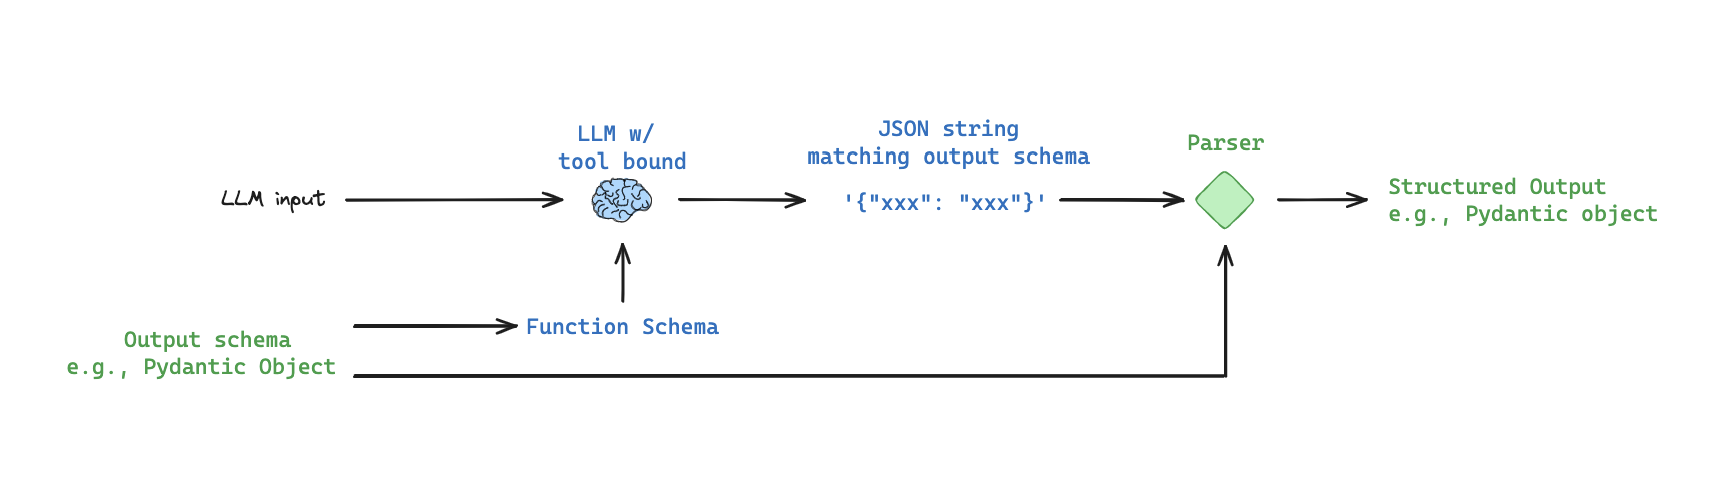

In [9]:
### Set LLM

mistral_model = "mistral-large-latest" # "open-mixtral-8x22b" 

In [12]:
### Retrieval Grader 

from langchain_mistralai import ChatMistralAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

# LLM with function call 
llm = ChatMistralAI(model=mistral_model, temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt 
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [11]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatMistralAI(model=mistral_model, temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

The agent memory can be categorized into short-term and long-term memory. Short-term memory is associated with in-context learning and is finite, limited by the context window length of the Transformer. On the other hand, long-term memory is facilitated by an external vector store that the agent can attend to at query time, enabling the retention and recall of information over extended periods. This external memory can alleviate the restriction of a finite attention span and is typically accessed via fast retrieval methods such as Maximum Inner Product Search (MIPS).


## Web Search Tool

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

# Graph 

We build the above workflow as a graph.

## Graph state

The graph `state` contains objects that we want to modify in the graph.

In [5]:
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents 
    """
    question : str
    generation : str
    web_search : str
    documents : List[str]

Each node in our graph is a function that:

(1) Take `state` as an input

(2) Modifies `state` (e.g., using an LLM)

(3) Outputs the modified `state`

Each edge decides which node to visit next.

In [13]:
from langchain.schema import Document

### Nodes 

def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score.binary_score
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}
    
def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question}

### Edges

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

## Build Graph

This follows the flow we outlined in the figure above.

In [14]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("websearch", web_search)  # web search

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

In [15]:
from pprint import pprint
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---RETRIEVE---
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
'Finished running: grade_documents:'
---WEB SEARCH---
'Finished running: websearch:'
---GENERATE---
'Finished running: generate:'
('The types of agent memory are short-term memory and long-term memory. '
 'Short-term memory, also known as working memory, stores information that is '
 'currently being used to carry out complex cognitive tasks such as learning '
 'and reasoning. It has a capacity of about 7 items and lasts for 20-30 '
 'seconds. Long-term memory, on the other hand, can store information for a '
 'remarkably long time, ranging from a few days to decades, with an '
 'essentially unlimited storage capacity. It has two subtypes: '
 'explicit/declarative me

Trace:

https://smith.langchain.com/public/90fc3ce2-3acb-44bd-b968-c8aae15ec1ac/r

In [10]:
inputs = {"question": "How does the AlphaCodium paper work?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---RETRIEVE---
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
'Finished running: grade_documents:'
---WEB SEARCH---
'Finished running: websearch:'
---GENERATE---
'Finished running: generate:'
('The AlphaCodium paper works by first sampling potential API calls from a '
 'language model (LM) given a specific sequence as a prefix and suffix. Then, '
 'it filters these annotations based on whether the API calls help the model '
 'predict future tokens, using a self-supervised loss to determine which API '
 'calls are actually helpful. Finally, each API call is executed to get '
 'corresponding results, and a weighted cross entropy loss is computed for the '
 'LM over tokens when the model is prefixed with the prompt, with two v

Trace:
 
https://smith.langchain.com/public/ffa5c8e8-5676-45a9-8e84-5c1145f3b1fa/r